In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*

stim_filename = "natural_scene.jpg"
filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])
A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])

w_rc_mix = itemgetter("w")(params["relay"]["Krc_mix"])
A_rc_mix_in, a_rc_mix_in = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_in"])
A_rc_mix_ex, a_rc_mix_ex = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_ex"])

response_map = {"no_fb": None, "fb_ex": None, "fb_in": None, "fb_mix": None}

## No feedback

In [3]:
network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                         A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                         w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                         w_rig=w_rig, A_rig=A_rig, a_rig=a_rig)

[relay] = get_neuron("Relay", network)
stimulus = pylgn.stimulus.create_natural_image(filename=stim_filename, duration=1e6*pq.ms)
network.set_stimulus(stimulus, compute_fft=True)
network.compute_response(relay)
    
response_map["no_fb"] = relay.response[0, :, :]

## Feedback excitation

In [4]:
network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                         A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                         w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                         w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                         w_rc_ex=w_rc_ex, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex)

[relay] = get_neuron("Relay", network)
stimulus = pylgn.stimulus.create_natural_image(filename=stim_filename, duration=1e6*pq.ms)
network.set_stimulus(stimulus, compute_fft=True)
network.compute_response(relay)
    
response_map["fb_ex"] = relay.response[0, :, :]

## Feedback inhibition

In [5]:
network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                         A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                         w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                         w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                         w_rc_in=w_rc_in, A_rc_in=A_rc_in, a_rc_in=a_rc_in)

[relay] = get_neuron("Relay", network)
stimulus = pylgn.stimulus.create_natural_image(filename=stim_filename, duration=1e6*pq.ms)
network.set_stimulus(stimulus, compute_fft=True)
network.compute_response(relay)
    
response_map["fb_in"] = relay.response[0, :, :]

## Mixed excitatory and inhibitory feedback

In [6]:

network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                         A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                         w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                         w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                         w_rc_in=w_rc_mix, A_rc_in=A_rc_mix_in, a_rc_in=a_rc_mix_in,
                         w_rc_ex=w_rc_mix, A_rc_ex=A_rc_mix_ex, a_rc_ex=a_rc_mix_ex)

[relay] = get_neuron("Relay", network)
stimulus = pylgn.stimulus.create_natural_image(filename=stim_filename, duration=1e6*pq.ms)
network.set_stimulus(stimulus, compute_fft=True)
network.compute_response(relay)

response_map["fb_mix"] = relay.response[0, :, :]

-------------
## Plotting

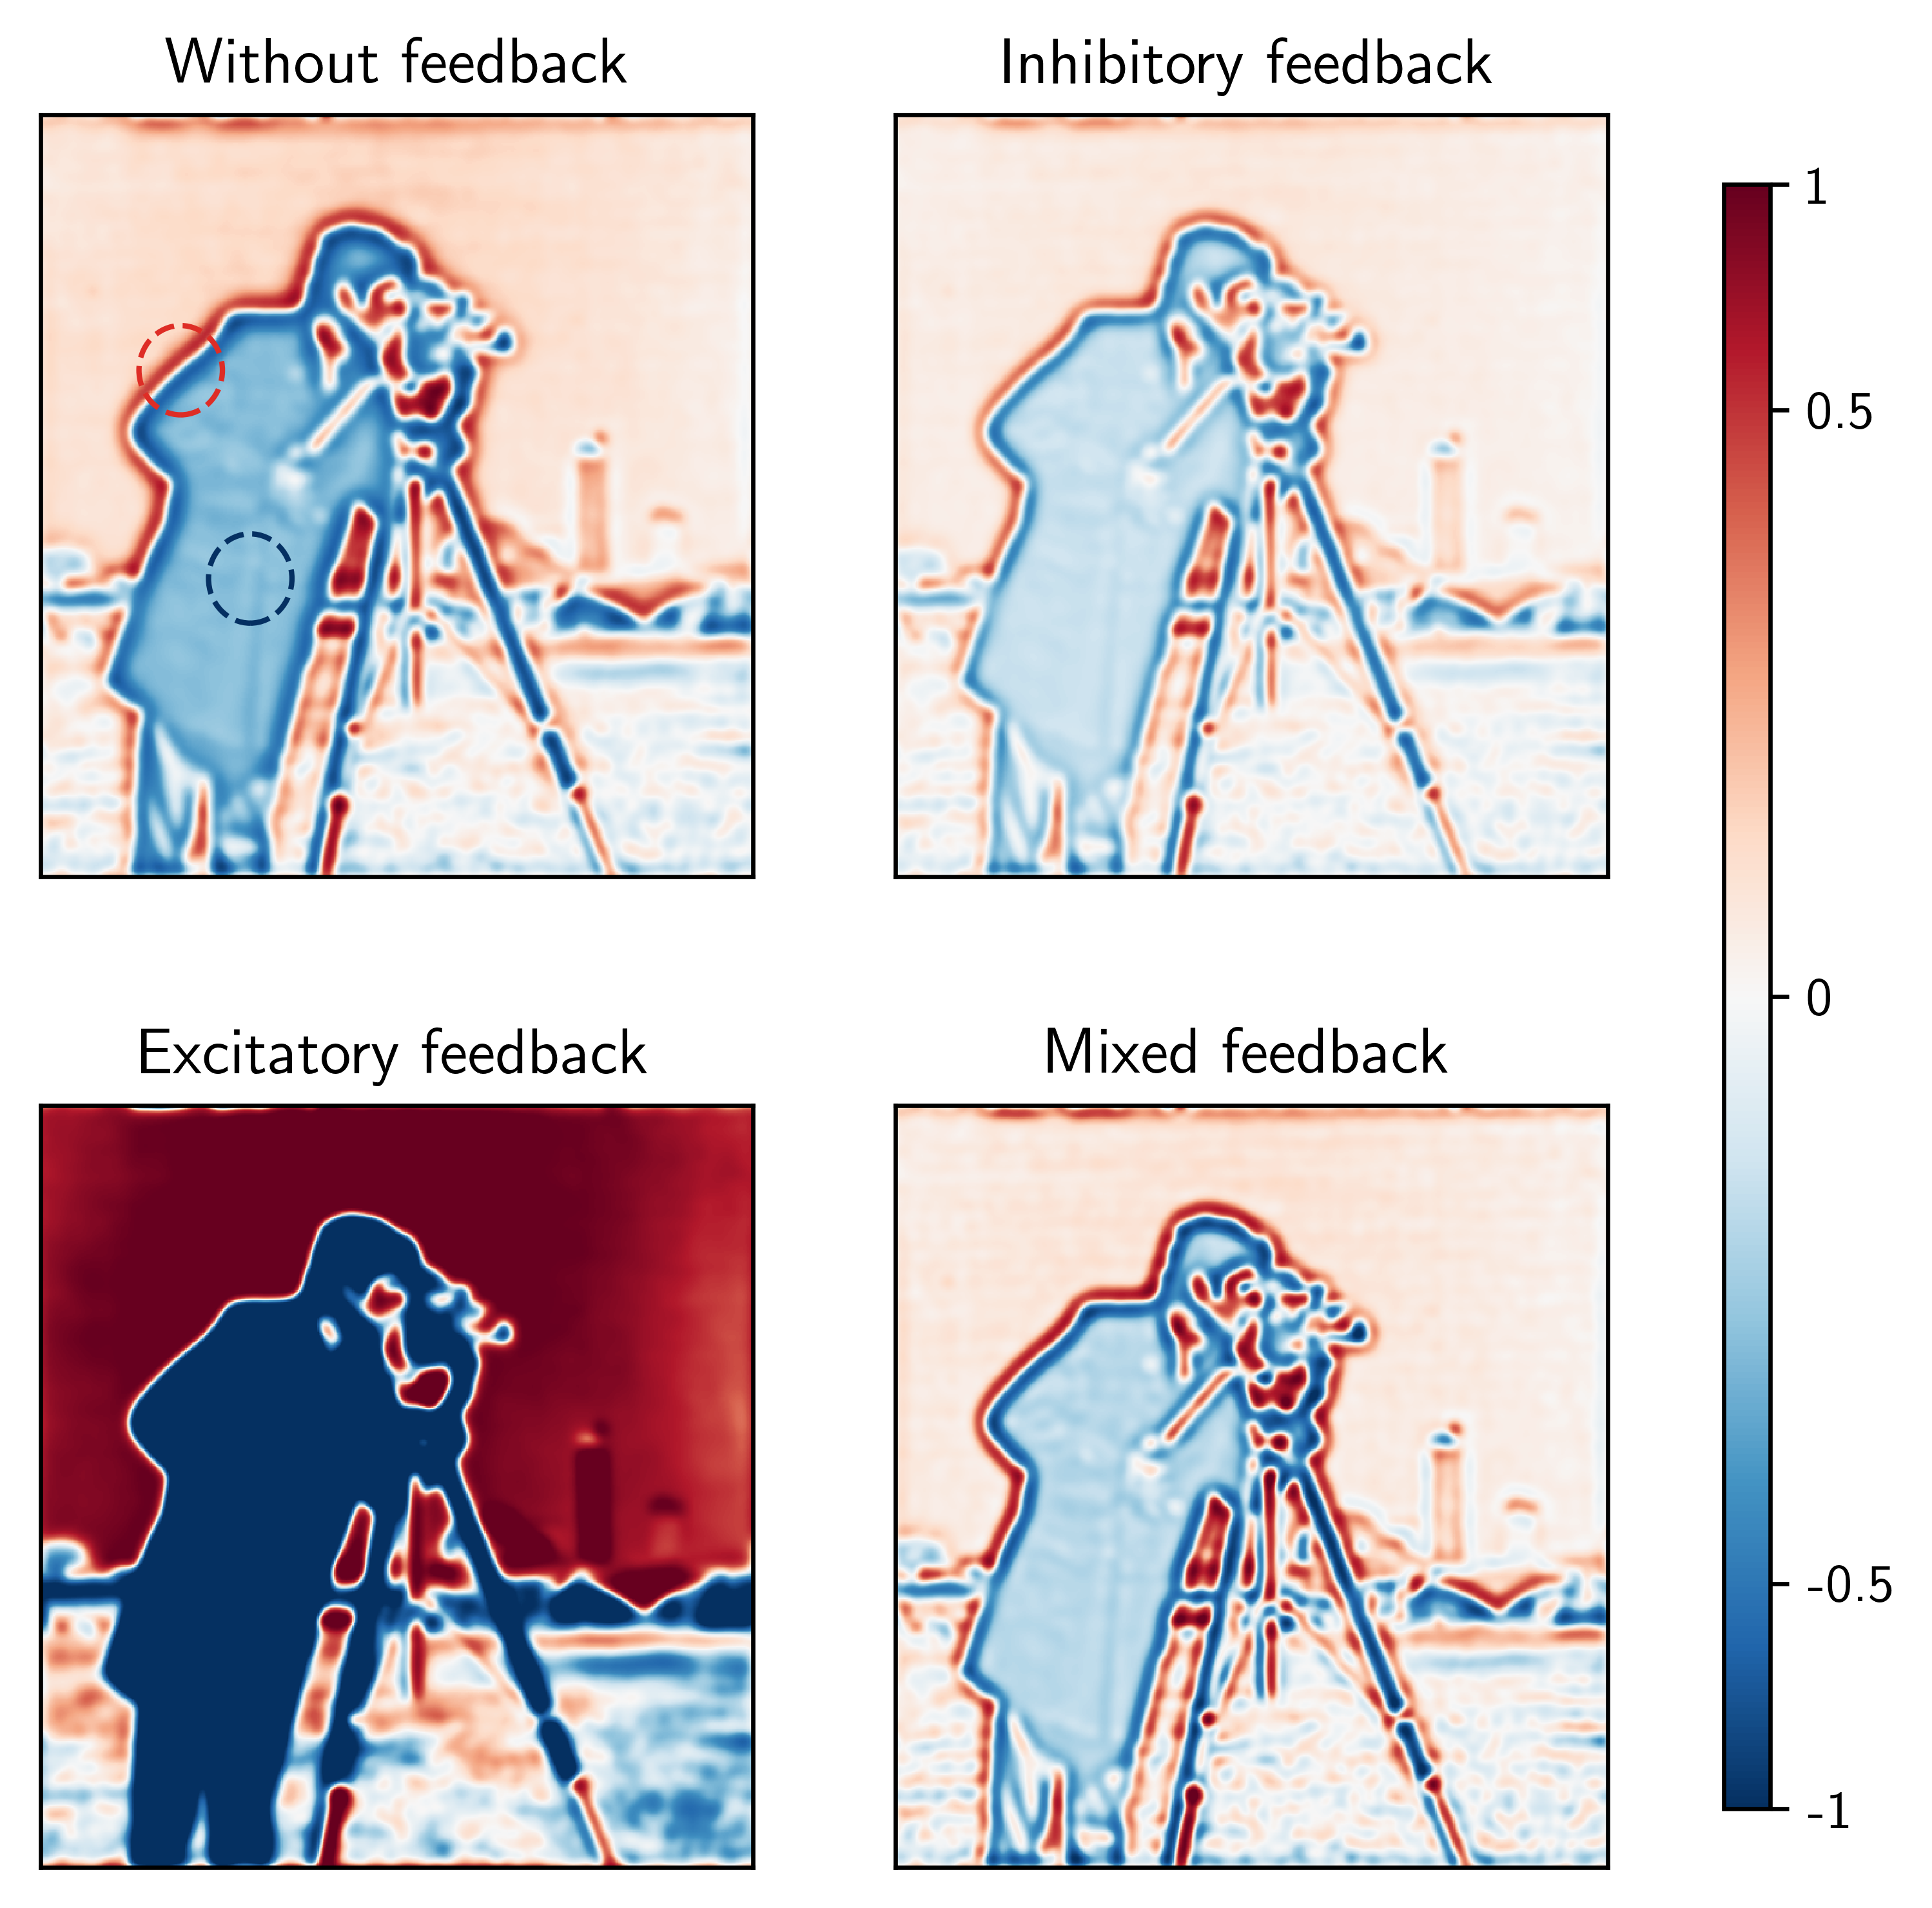

In [7]:
cmap = "RdBu_r"
interpolation = "none"
vmin = -1.0
vmax = 1.0
linthresh = 0.4
linscale=1

fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey="row", sharex="col")
fig.subplots_adjust(hspace=0.3)


ax = axarr[0, 0]
im = ax.imshow((response_map["no_fb"]/response_map["no_fb"].max()).magnitude, cmap=cmap, 
               norm=colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh, linscale=linscale), 
               interpolation=interpolation, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
ax.set_title("Without feedback")
ax.grid(False)
ax.set_yticks([])
ax.set_xticks([])

# circle 
circ_l = plt.Circle((150, 200), 30, fill=False, edgecolor="#053062", linewidth=1, linestyle="--")
circ_h = plt.Circle((100, 340), 30, fill=False, edgecolor="#de2d26", linewidth=1, linestyle="--")
ax.add_artist(circ_l)
ax.add_artist(circ_h)

ax = axarr[0, 1]
im = ax.imshow((response_map["fb_in"]/response_map["no_fb"].max()).magnitude, cmap=cmap, 
               norm=colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh, linscale=linscale), 
               interpolation=interpolation, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
ax.set_title("Inhibitory feedback")
ax.grid(False)
ax.set_yticks([])
ax.set_xticks([])


ax = axarr[1, 0]
im = ax.imshow((response_map["fb_ex"]/response_map["no_fb"].max()).magnitude, cmap=cmap, 
               norm=colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh, linscale=linscale), 
               interpolation=interpolation, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
ax.set_title("Excitatory feedback")
ax.grid(False)
ax.set_yticks([])
ax.set_xticks([])


ax = axarr[1, 1]
im = ax.imshow((response_map["fb_mix"]/response_map["no_fb"].max()).magnitude, cmap=cmap, 
               norm=colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh, linscale=linscale), 
               interpolation=interpolation, origin="lower", aspect="auto", vmin=vmin, vmax=vmax)
ax.set_title("Mixed feedback")
ax.grid(False)
ax.set_yticks([])
ax.set_xticks([])

fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[vmin, vmin/2,  0, vmax/2, vmax])
cbar.set_ticklabels([-1, -0.5, 0, 0.5, 1])